For this project, we will be creating a naive Bayes classifier from scratch, and use it to classify iris flowers in the extended iris dataset, found [here](https://www.kaggle.com/code/samybaladram/iris-dataset-extended-quick-data-exploration). This dataset is an extension of the classic and well-known [iris dataset](https://archive.ics.uci.edu/dataset/53/iris). However, because the extended dataset includes a tremendous number of new features, we will trim the features down to match the features of the traditional dataset. While one can certainly work with these new features, it complicates the project by having us consider features that are not of Gaussian distributions, and we would like to keep it simple.

Before we start, we ought to briefly review Bayes' Theorem and how it plays into the classifier.

## The math

Bayes' Theorem simply states that given events $A$ and $B$ with the probability $P(B) \neq 0$, the conditional probability $P(A \vert B)$ is given by
$$P(A \vert B) = \frac{P(B \vert A) \cdot P(A)}{P(B)}$$
Suppose now that $B$ is a feature vector
$$B = (b_1, b_2, \ldots, b_n)$$
We assume the "naive" assumption of "naive Bayes," which is to assume all such $b_i$'s to be [mutually independent](https://en.wikipedia.org/wiki/Conditional_independence). That is,
$$P(b_1, b_2, \ldots, b_n) = P(b_1) \cdot P(b_2) \cdots P(b_n)$$
Then, applying the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)) and the definition of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) to Bayes' Theorem above, we arrive at
$$P(A \vert B) = \frac{P(b_1 \vert A) \cdots P(b_n \vert A) \cdot P(A)}{P(B)}$$
As we'll be using $X$ and $y$ for our model, let's just do the substitutions now:
$$P(y \vert X) = \frac{P(x_1 \vert y) \cdots P(x_n \vert y) \cdot P(y)}{P(X)}$$

Now before we do any more, let's load up the data and see what we're working with.

---

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('dataset\\iris_extended.csv')

df.head()

,species,elevation,soil_type,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area,sepal_aspect_ratio,...,sepal_to_petal_length_ratio,sepal_to_petal_width_ratio,sepal_petal_length_diff,sepal_petal_width_diff,petal_curvature_mm,petal_texture_trichomes_per_mm2,leaf_area_cm2,sepal_area_sqrt,petal_area_sqrt,area_ratios
0,setosa,161.8,sandy,5.16,3.41,1.64,0.26,17.5956,0.4264,1.513196,...,3.146341,13.115385,3.52,3.15,5.33,18.33,53.21,4.194711,0.652993,41.265478
1,setosa,291.4,clay,5.48,4.05,1.53,0.37,22.1940,0.5661,1.353086,...,3.581699,10.945946,3.95,3.68,5.90,20.45,52.53,4.711051,0.752396,39.205087
2,setosa,144.3,sandy,5.10,2.80,1.47,0.38,14.2800,0.5586,1.821429,...,3.469388,7.368421,3.63,2.42,5.66,24.62,50.25,3.778889,0.747395,25.563910
3,setosa,114.6,clay,4.64,3.44,1.53,0.17,15.9616,0.2601,1.348837,...,3.032680,20.235294,3.11,3.27,4.51,22.91,50.85,3.995197,0.510000,61.367166
4,setosa,110.9,loamy,4.85,2.87,1.23,0.26,13.9195,0.3198,1.689895,...,3.943089,11.038462,3.62,2.61,4.03,21.56,40.57,3.730885,0.565509,43.525641


In [2]:
# Dropping all the new columns so that we are in-line with the classic dataset. See first paragraph of notebook
columns_to_keep = ['species', 'sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = df.drop(columns=df.columns.difference(columns_to_keep))

df.head()

,species,sepal_length,sepal_width,petal_length,petal_width
0,setosa,5.16,3.41,1.64,0.26
1,setosa,5.48,4.05,1.53,0.37
2,setosa,5.10,2.80,1.47,0.38
3,setosa,4.64,3.44,1.53,0.17
4,setosa,4.85,2.87,1.23,0.26


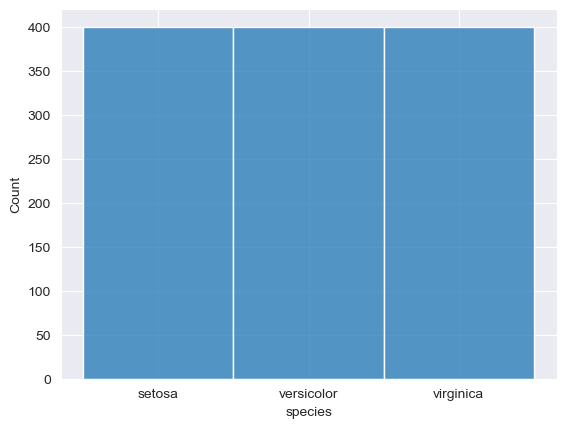

In [3]:
# Taking a look at the different classes of irises
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.histplot(df['species']);

It looks like there are 400 types of each iris in the dataset. We should check a correlation heatmap to see if any of the columns are correlated to one another, although it may make little difference within the context of a naive Bayes model.

Since some columns are not quantitative, let's make replacements to the following columns:
- species
    - setosa = 0
    - versicolor = 1
    - virginica = 2

In [10]:
df['species'] = df['species'].replace({'setosa': 0, 'versicolor': 1, 'virginica': 2}).astype('int')

df.head()

,species,sepal_length,sepal_width,petal_length,petal_width
0,0,5.16,3.41,1.64,0.26
1,0,5.48,4.05,1.53,0.37
2,0,5.10,2.80,1.47,0.38
3,0,4.64,3.44,1.53,0.17
4,0,4.85,2.87,1.23,0.26


Now that everything is numerical, we can create a correlation heatmap.

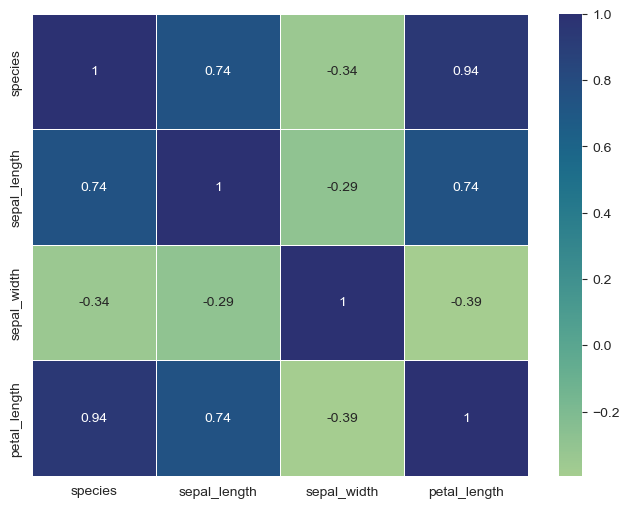

In [5]:
corr = df.iloc[:,:-1].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, cmap='crest', annot=True, linewidths=0.5, ax=ax);

As we can see, there does seem to be a strong correlation between `petal_length` and `species`, but since `species` is what we are trying to predict, it will not be a feature anyway. If we did have features that were extremely highly correlated, as may be the case in the original extended dataset before we dropped the columns, we could decide whether we would wish to drop any of the columns or not, so as to reduce dimensionality of the model.

## The math, cont.

Recalling what we have above:
$$P(y \vert X) = \frac{P(x_1 \vert y) \cdots P(x_n \vert y) \cdot P(y)}{P(X)}$$
We wish to select the class $y$ which maximizes the posterior probability $P(y \vert X)$, so we choose
$$\begin{align*}
\hat{y} &= \argmax_y P(y \vert X)\\
&= \argmax_y \frac{P(x_1 \vert y) \cdots P(x_n \vert y) \cdot P(y)}{P(X)}\\
&= \argmax_y P(x_1 \vert y) \cdots P(x_n \vert y) \cdot P(y) \qquad \text{(since } P(X) \text{ does not matter here)}
\end{align*}$$

Note that $P(x_i \vert y)$ is a real number between 0 and 1, and so multiplying many of these together may result in extremely small numbers which may cause overflow issues. In order to prevent this, one can apply $\log$, which yields
$$\hat{y} = \argmax_y \log(P(x_1 \vert y)) + \cdots + \log(P(x_n \vert y)) + \log(P(y))$$

Finally, we want to model the likelihood $P(x_i \vert y)$.

---

Before we continue on, we should first look at the distributions of the data.

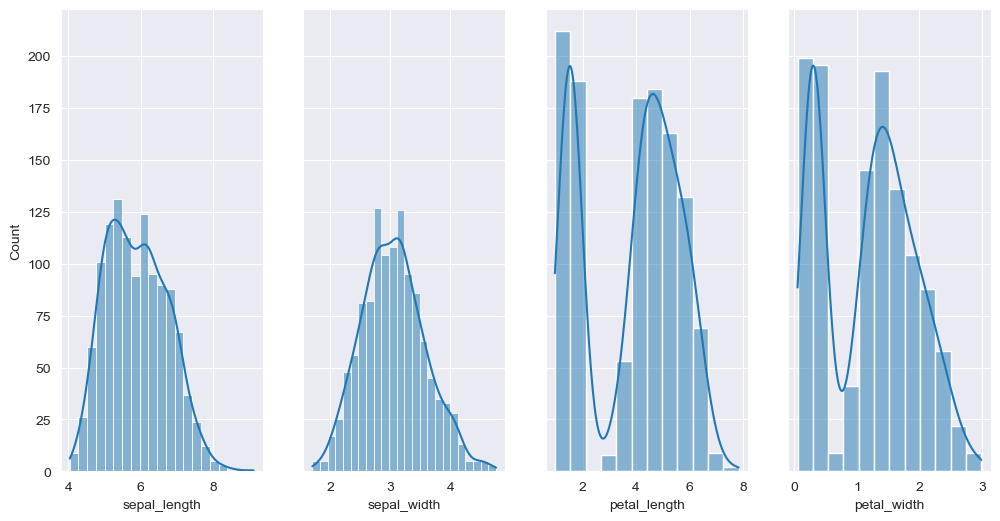

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(12, 6), sharey=True)
for i in range(4):
    sns.histplot(df, ax=ax[i], x=df[df.columns[i+1]], kde=True);

Notice that `petal_length` and `petal_width` are not Gaussian (normal) distributions, while we will be using a Gaussian classifying model. This is because, for one, it is simply more convenient, as naive Bayes does not assume a particular distribution upon the features themselves. There may be a performance hit to the model, but we are willing to make that tradeoff to not overcomplicate the project. Note also that we will be testing the accuracy of our model against that of scikit-learn's, and we will be using scikit-learn's Gaussian model as well.

## Building the model

To start, let's calculate the priors $P(y)$ for all possible $y$. Then, we'd like to calculate the class conditional probabilities that make up the likelihood $P(x_1 \vert y) \cdots P(x_n \vert y)$. For this, we'll assume a Gaussian distribution. Hence, the class conditional probabilities are given by the Gaussian probability density function
$$P(x_i \vert y) = \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot \exp \left( {-\frac{1}{2} \left( \frac{x_i - \mu}{\sigma} \right)^2} \right)$$
where $\mu$ is the mean (or expected value) of the distribution and $\sigma$ is the standard deviation.

One we put these two together we have our model.

In [7]:
class NBGaussian:
    def fit(self, X, y):
        self.classes = np.unique(y)

        # Initialize array to store priors
        self.class_prior = np.zeros(len(self.classes))

        # Initialize mean and variance arrays of each feature for given class
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        
        for (i, c) in enumerate(self.classes):
            # Data belonging to current class
            X_c = X[y == c]

            # Calculate class prior probability
            self.class_prior[i] = len(X_c) / len(X)

            # Calculate mean and variance for each feature and class
            self.mean[i, :] = X_c.mean(axis=0)
            self.var[i, :] = X_c.var(axis=0)
    
    def predict(self, X):
        probs = []

        for i, c in enumerate(self.classes):

            # Calculate log of prior
            prior = np.log(self.class_prior[i])

            # Calculate likelihood using Gaussian probability density function
            posterior = np.sum(np.log(self.gaussian_pdf(X, self.mean[i, :], self.var[i, :])), axis=1)

            # Calculate log probability for each class
            probs.append(prior + posterior)

        # Return class with highest probability for each sample
        return self.classes[np.argmax(probs, axis=0)]
    
    def gaussian_pdf(self, X, mean, var):
        return np.exp(-((X - mean) ** 2) / (2 * var)) / np.sqrt(2 * np.pi * var)

Finally, let's train the model and see how it performs.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X = df.drop('species', axis=1)
y = df['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = NBGaussian()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred, average='weighted')

print(confusion_matrix(y_test, pred))
print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

[[87  0  0]
 [ 0 71  2]
 [ 0  4 76]]
Accuracy score: 0.975
F1 score: 0.9750106910708176


## Comparison with sklearn's model

In [9]:
from sklearn.naive_bayes import GaussianNB

clf_sk = GaussianNB()
clf_sk.fit(X_train, y_train)
y_pred_sk = clf_sk.predict(X_test)

accuracy_sk = accuracy_score(y_test, y_pred_sk)
f1_sk = f1_score(y_test, y_pred_sk, average='weighted')

print(confusion_matrix(y_test, y_pred_sk))
print(f'Accuracy score: {accuracy_sk}')
print(f'F1 score: {f1_sk}')

[[87  0  0]
 [ 0 71  2]
 [ 0  4 76]]
Accuracy score: 0.975
F1 score: 0.9750106910708176


It appears we have gotten the exact same results as scikit-learn's model; a success!